# CUSTOMER CHURN

## Business Understanding


### Explanation of features

NAMES OF COLUMNS AND DEFINITIONS

* REGION:---------The location of each client
* TENURE:---------Duration in the network
* MONTANT:--------Top-up amount
* FREQUENCE_RECH:-A number of times the customer refilled
* REVENUE:--------Monthly income of each client
* ARPU_SEGMENT:---Income over 90 days/3
* FREQUENCE:------Number of times the client has made an income
* DATA_VOLUME:----Number of connections
* ON_NET:---------Inter expresso call
* ORANGE:---------Call to Orange
* TIGO:-----------Call to Tigo
* ZONE1:----------Call to Zones 1
* ZONE2:----------Call to Zones 2
* MRG:------------A client who is going
* REGULARITY:-----Number of times the client is active for 90 days
* TOP_PACK:-------The most active packs
* FREQ_TOP_PACK:--Number of times the client has activated the top pack packages
* CHURN:----------Variable to predict - Target


### Business Goal

* To develop a predictive model that determines the likelihood for a customer to churn(to stop purchasing airtime and data from the client)

* To identify and understand factors that influences customer churn

### Hypothesis & Analytical Questions

Hypothesis 
* Null Hypothesis (H_o): There is no significant relationship between the tenure and customer churn

* Alternate Hypothesis (H_a): There is a relationship between the tenure and customer churn

Analytical Questions

1) What is the percentage of those who churned and those who did not?
    * This is a quick rapid assessment on how the company is doing. 

2) How does tenure impact the likelihood of churning?
    * Identifying which group of customers are most likely to leave is a first step to finding out their issues and addressing such issues.    

3) What is the distribution of churn per region?
    * Identify the region with high attrition rate. Is the problem regional based - poor network in the region, accessibility to data? 

4) Which top up amount (MONTANT)  churned most?
    * Observe if particular top-up amount are more likely to be affected

5) What is the effect of the number of times a customer activates top pack packages and likelihood of churning?

6) Is there an effect of regularity on churn?
Does the number of times the client is active in 90 days say anything about the posibility of churning?


## Data Understanding


### Import libraries

In [32]:
import pandas as pd
import numpy as np

import pyodbc


import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from scipy.stats import pointbiserialr
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

### Load dataset

In [2]:
# Read the CSV file into a Pandas DataFrame
# Display names of columns

df = pd.read_csv('dataset\Train (2).csv')
df.columns

Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK',
       'CHURN'],
      dtype='object')

### EDA

#### Inspect Dataset

In [3]:
# use .info to get a summary(index, column data types, non-null values) of dataframe. 
# we have 19 columns with 1,077,024 entries

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077024 entries, 0 to 1077023
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1077024 non-null  object 
 1   REGION          652687 non-null   object 
 2   TENURE          1077024 non-null  object 
 3   MONTANT         699139 non-null   float64
 4   FREQUENCE_RECH  699139 non-null   float64
 5   REVENUE         714669 non-null   float64
 6   ARPU_SEGMENT    714669 non-null   float64
 7   FREQUENCE       714669 non-null   float64
 8   DATA_VOLUME     547261 non-null   float64
 9   ON_NET          683850 non-null   float64
 10  ORANGE          629880 non-null   float64
 11  TIGO            432250 non-null   float64
 12  ZONE1           84898 non-null    float64
 13  ZONE2           68794 non-null    float64
 14  MRG             1077024 non-null  object 
 15  REGULARITY      1077024 non-null  int64  
 16  TOP_PACK        626129 non-null   ob

In [4]:
# check for duplicates values in dataset
# there are no duplicates

df.duplicated().sum()

0

<Axes: >

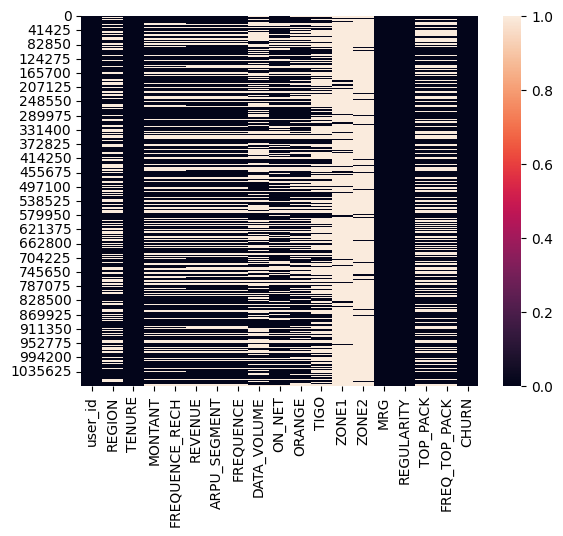

In [5]:
# show missing data in a heatmap

sns.heatmap(df.isnull())

In [6]:
# count the number of missing (null or NaN) values in each column
# compute the percentage of missing values in each column to decide which columns to drop
# drop columns with more than 50% missing values

missing_values = df.isnull().sum()

# Calculate the percentage of missing values for each column
percentage_missing = (missing_values / len(df)) * 100


# Display the percentage of missing values for each column with 2 decimal places
print(percentage_missing.round(2))

user_id            0.00
REGION            39.40
TENURE             0.00
MONTANT           35.09
FREQUENCE_RECH    35.09
REVENUE           33.64
ARPU_SEGMENT      33.64
FREQUENCE         33.64
DATA_VOLUME       49.19
ON_NET            36.51
ORANGE            41.52
TIGO              59.87
ZONE1             92.12
ZONE2             93.61
MRG                0.00
REGULARITY         0.00
TOP_PACK          41.86
FREQ_TOP_PACK     41.86
CHURN              0.00
dtype: float64


In [7]:
# Check Unique values counts for each variable/column 

for i in df.columns:
    print('No. of unique values in ',i,'is', df[i].nunique())

No. of unique values in  user_id is 1077024
No. of unique values in  REGION is 14
No. of unique values in  TENURE is 8
No. of unique values in  MONTANT is 4357
No. of unique values in  FREQUENCE_RECH is 119
No. of unique values in  REVENUE is 31810
No. of unique values in  ARPU_SEGMENT is 14062
No. of unique values in  FREQUENCE is 91
No. of unique values in  DATA_VOLUME is 32459
No. of unique values in  ON_NET is 8202
No. of unique values in  ORANGE is 2674
No. of unique values in  TIGO is 1105
No. of unique values in  ZONE1 is 482
No. of unique values in  ZONE2 is 394
No. of unique values in  MRG is 1
No. of unique values in  REGULARITY is 62
No. of unique values in  TOP_PACK is 126
No. of unique values in  FREQ_TOP_PACK is 206
No. of unique values in  CHURN is 2




The given dataset includes 19 variables with 15 numeric variables and 4 categorical variables. It consists of 1,077,024 rows of customer activity. There are missing values as shown above and no duplicate values in the dataset. 


The following columns will be dropped because of redundancy and percentage of missing values.  
* user_id : this column is redundant because its roles is captured by the DataFrame's index
* TIGO: It has a large percentage of missing values (59.8%)
* ZONE1: It has a large percentage of missing values (92.1%)
* ZONE2: it has a large percentage of missing values (93.6%)

In [8]:
#list columns to drop and drop them inplace
# 'user_id', 'TIGO', 'ZONE1', and 'ZONE2' dropped

columns_to_drop = ['user_id','TIGO','ZONE1','ZONE2']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,DAKAR,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,NO,62,On net 200F=Unlimited _call24H,30.0,0
1,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,0
3,SAINT-LOUIS,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,NO,61,"Data:490F=1GB,7d",7.0,0
4,DAKAR,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,NO,56,All-net 500F=2000F;5d,11.0,0


In [9]:
# check the shape of our dataframe
# there are 1,077,024 rows and 15 columns

df.shape

(1077024, 15)

In [10]:
# show the statistical description of our dataset. The count, mean, standard deviation, median, minimun, and maximum values

df.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,699139.0,5529.210895,7104.737952,20.0,1000.0,3000.0,7350.0,470000.0
FREQUENCE_RECH,699139.0,11.523756,13.261938,1.0,2.0,7.0,16.0,131.0
REVENUE,714669.0,5506.050798,7175.625010,1.0,1000.0,3000.0,7360.0,532177.0
ARPU_SEGMENT,714669.0,1835.355961,2391.870902,0.0,333.0,1000.0,2453.0,177392.0
FREQUENCE,714669.0,13.974439,14.687059,1.0,3.0,9.0,20.0,91.0
DATA_VOLUME,547261.0,3368.801722,12898.928039,0.0,0.0,258.0,2905.0,1702309.0
ON_NET,683850.0,277.065798,874.315378,0.0,5.0,27.0,156.0,50809.0
ORANGE,629880.0,95.160804,203.020261,0.0,7.0,29.0,99.0,12040.0
REGULARITY,1077024.0,28.044496,22.288610,1.0,6.0,24.0,51.0,62.0
FREQ_TOP_PACK,626129.0,9.262446,12.242316,1.0,2.0,5.0,12.0,624.0


In [11]:
# show distribution of object data types
# Use .describe(include='O') for object dtype columns

object_stats = df.describe(include='O').T

print(object_stats)

            count unique                    top     freq
REGION     652687     14                  DAKAR   256259
TENURE    1077024      8           K > 24 month  1021853
MRG       1077024      1                     NO  1077024
TOP_PACK   626129    126  All-net 500F=2000F;5d   158779


Drop MRG and TOP_PACK columns does not add valuable insights to the analysis
* MRG has only one unique value 
* TOP_PACK has 126 unique values
* Also FREQ_TOP_PACK column will capture the same information as TOP_PACK column for our analysis

In [12]:
# drop MRG and TOP_PACK columns inplace
# this removes the two columns from the dataset

columns_to_drop = ['MRG','TOP_PACK']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,FREQ_TOP_PACK,CHURN
0,DAKAR,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,62,30.0,0
1,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,0
2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0
3,SAINT-LOUIS,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,61,7.0,0
4,DAKAR,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,56,11.0,0


In [13]:
df.columns

Index(['REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE',
       'REGULARITY', 'FREQ_TOP_PACK', 'CHURN'],
      dtype='object')

In [14]:
print('No. of customers Churning :', df[df['CHURN']==True].CHURN.count()) # Total number of customers churning

churn_df = df[df['CHURN']==True] # assign variable to churned data

#Total number of unique regions
print('No. of unique regions :', df['REGION'].nunique())

#Total number of unique top-up amount
print('No. of unique top-up amount :', df['MONTANT'].nunique())


No. of customers Churning : 201993
No. of unique regions : 14
No. of unique top-up amount : 4357


#### Visualizations

##### Univariate Analysis

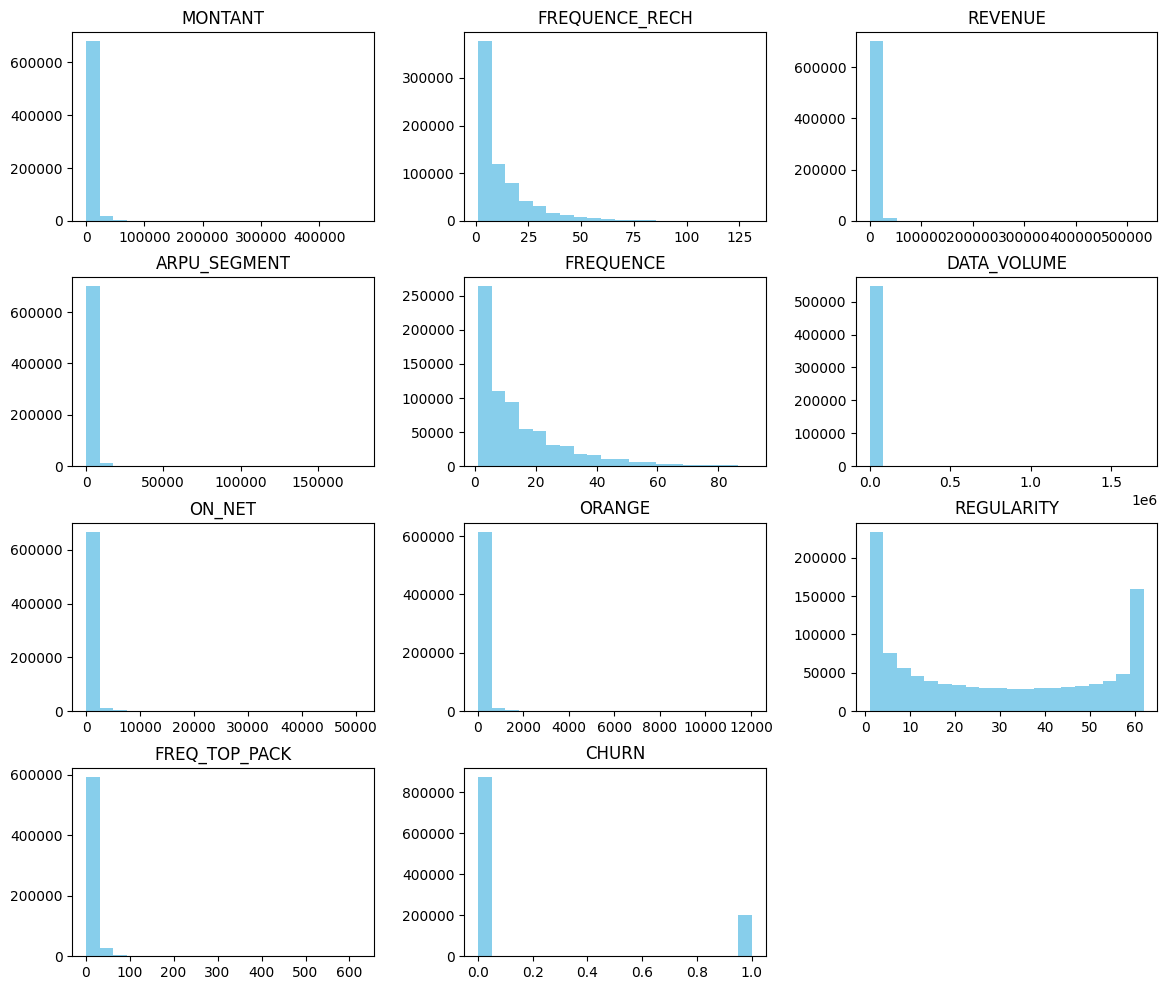

In [15]:
# visualize all integer columns

df.hist(figsize=(14,12),grid=False, bins=20, color='skyblue')
plt.show()

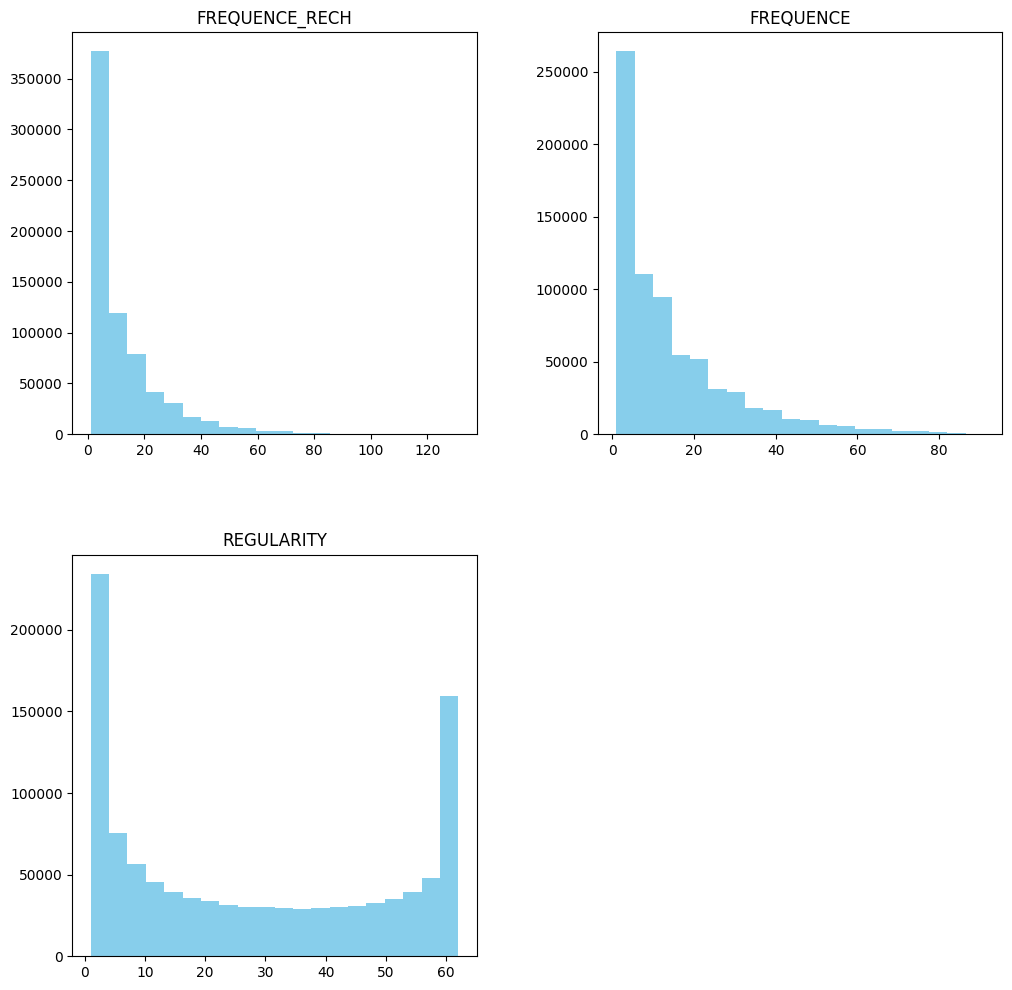

In [16]:
# visualize selected integer columns


select_columns=['FREQUENCE_RECH','FREQUENCE','REGULARITY']
df[select_columns].hist(figsize=(12,12), grid=False, bins=20, color='skyblue')
plt.show()

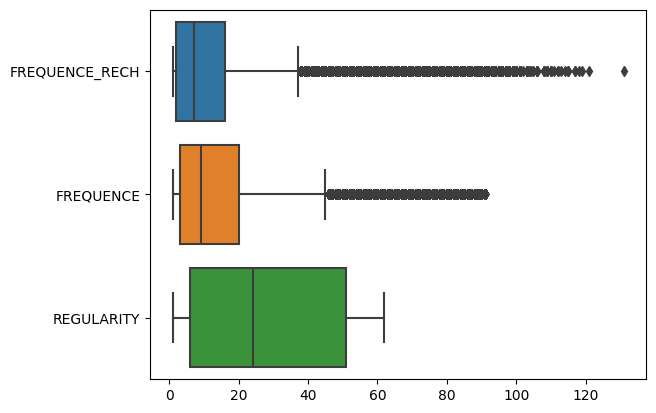

In [17]:
# check outliers with boxplots
# this shows that apart from 'REGULARITY' column, all columns have outliers

df_without_large_columns=df.drop(['DATA_VOLUME','REVENUE','MONTANT','ARPU_SEGMENT','ON_NET','ORANGE','FREQ_TOP_PACK','CHURN'], axis=1)
#sns.boxplot(data=df)
sns.boxplot(data=df_without_large_columns, orient='h')
plt.show()

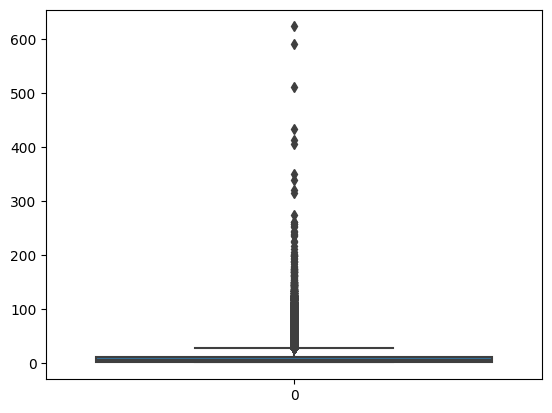

<Figure size 1400x1400 with 0 Axes>

In [18]:
# boxplot on 'FREQ_TOP_PACK' column

sns.boxplot(data=df['FREQ_TOP_PACK'])
plt.figure(figsize=(14,14))
plt.show()

##### Bivariate Analysis

In [58]:
region_revenue

,TENURE,REVENUE
0,D 3-6 month,5.932790e+05
1,E 6-9 month,4.410933e+06
2,F 9-12 month,1.478173e+07
3,G 12-15 month,2.038241e+07
4,H 15-18 month,3.599267e+07
5,I 18-21 month,6.874135e+07
6,J 21-24 month,2.156604e+07
7,K > 24 month,3.768535e+09


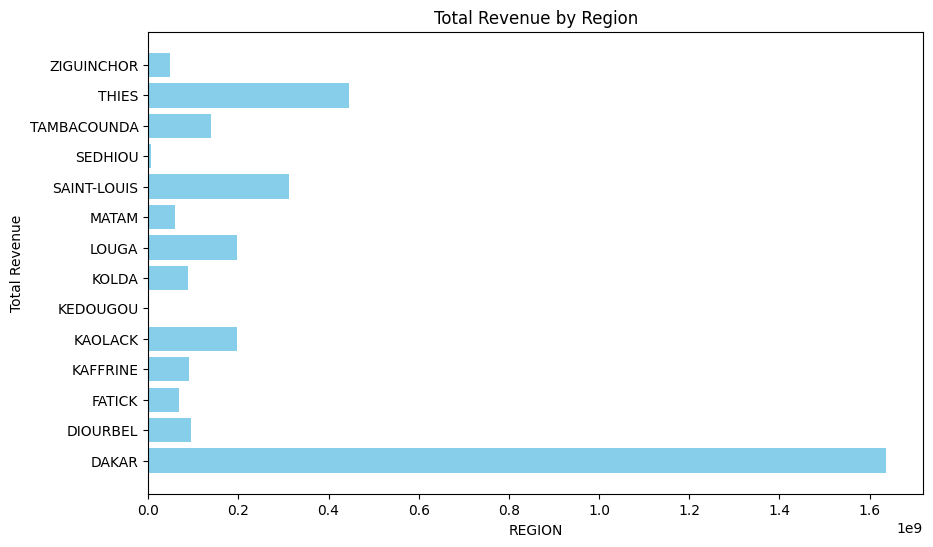

In [19]:
# Plotting a bar chart for aggregated revenue by region
# Aggregate revenue based on regions
region_revenue = df.groupby('REGION')['REVENUE'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.barh(region_revenue['REGION'], region_revenue['REVENUE'], color='skyblue')
plt.xlabel('REGION')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Region')
plt.show()

Dakar was the region with the highest monthly revenue (over 1.6 billion) by clients, followed by Thies with 500 million. Saint-Louis, Louga, and Koalack follows respectively. Kedougou was the lowest in terms of revenue.

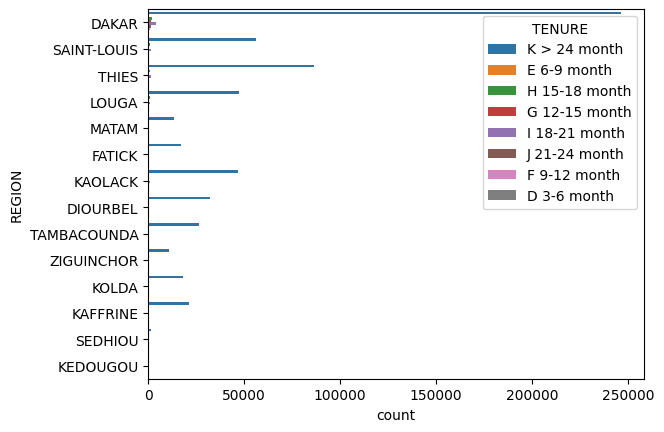

In [36]:
# Visualize tenure based on regions
# This shows that K > 24 month is the highest representation in all regions with DAKAR leading

sns.countplot(y='REGION', hue='TENURE', data=df)
plt.show()

Visualizing the different tenures based on regions, the 'K > 24 month' was the highest count for almost all regions. This shows that most customers have stayed for over 24 months. Dakar alone counts over 250,000 clients followed by about 100,000 customers in Thies. 

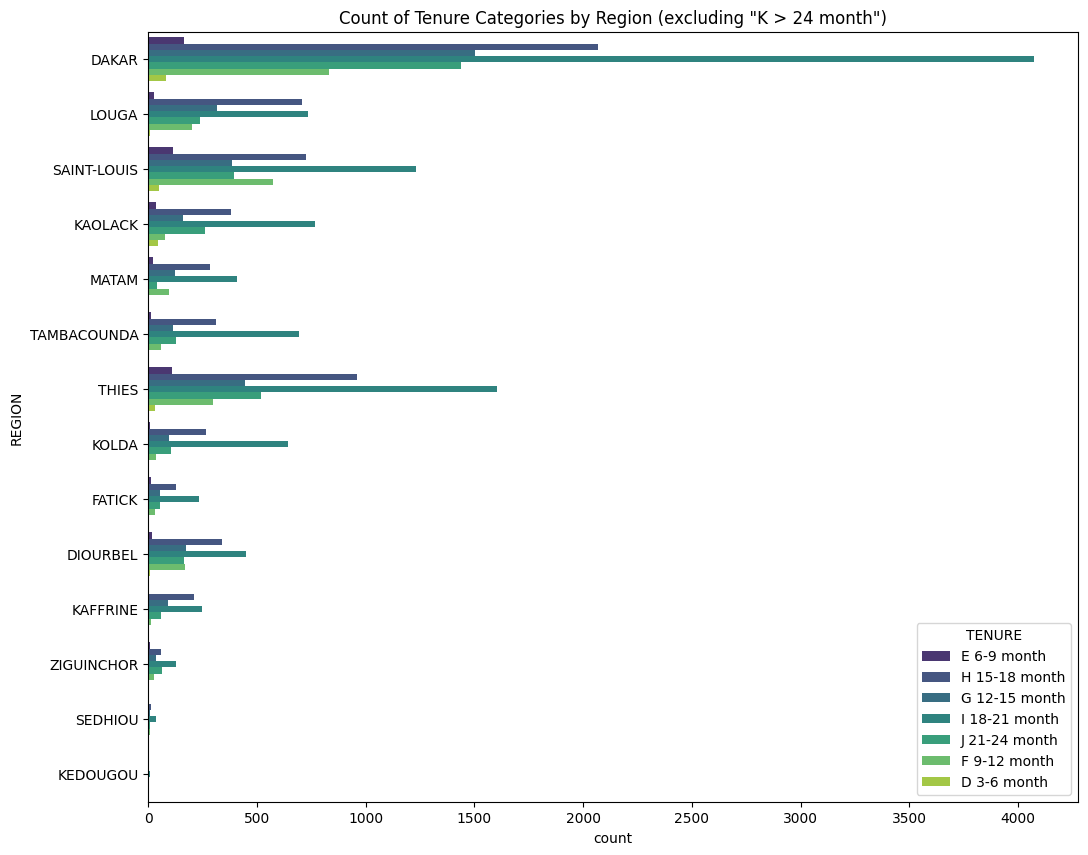

In [49]:
# Filter out 'K > 24 months' to see clearly how other tenures look like per region


filtered_data = df[df['TENURE'] != 'K > 24 month']

plt.figure(figsize=(12, 10))

sns.countplot(y='REGION', hue='TENURE', data=filtered_data, palette='viridis')
plt.title('Count of Tenure Categories by Region (excluding "K > 24 month")')
plt.show()

When we take out the 'K > 24 month' to get a clear view of the other ranges, we observe that 'I 18-21 month' is the highest count in almost all the remaining regions. 'H 15-18 month' comes next as the third highest count in terms of tenure. 

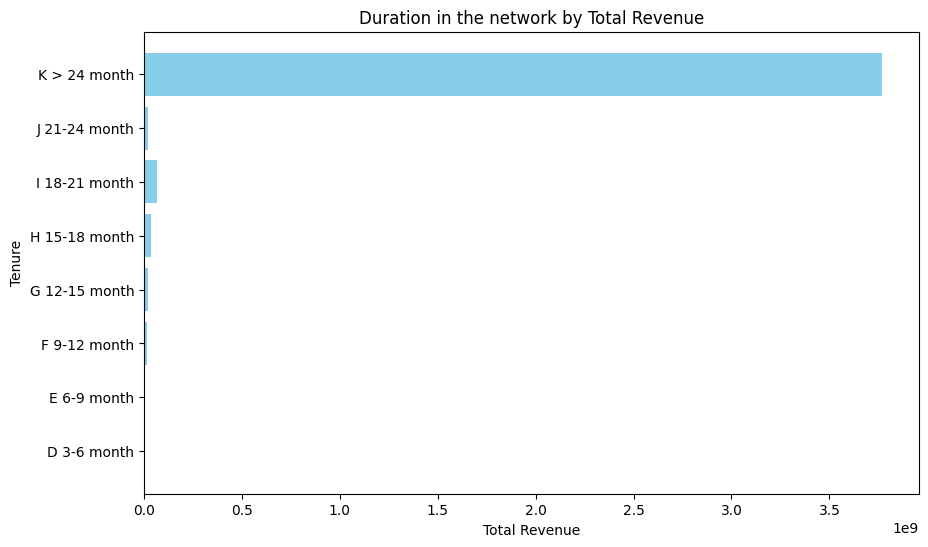

In [59]:
# Plotting a bar chart for aggregated revenue by tenure
# Aggregate revenue based on tenure
tenure_revenue = df.groupby('TENURE')['REVENUE'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.barh(tenure_revenue['TENURE'], tenure_revenue['REVENUE'], color='skyblue')
plt.xlabel('Total Revenue')
plt.ylabel('Tenure')
plt.title('Duration in the network by Total Revenue')
plt.show()

When we sum the total revenue based on the duration in the network, we observe that those who have stayed in the network more than 24 months has the highest aggregate total revenue of over 3.5 billion. The next tenure ranges that comes close is '18-21 months' which is less than 100million. 

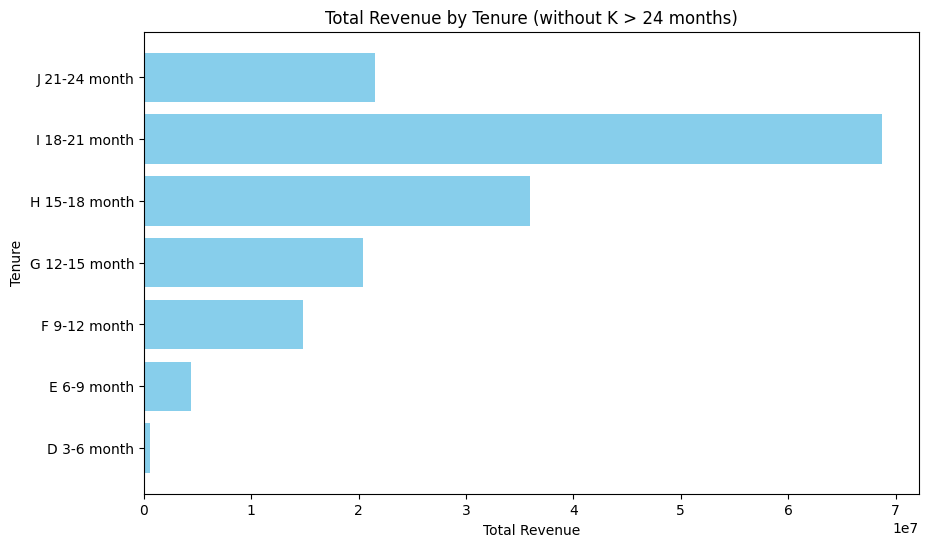

In [60]:
# Plotting a bar chart for aggregated revenue by tenure without K > 24 month
# Aggregate revenue based on tenure

tenure_revenue = filtered_data.groupby('TENURE')['REVENUE'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.barh(tenure_revenue['TENURE'], tenure_revenue['REVENUE'], color='skyblue')
plt.xlabel('Total Revenue')
plt.ylabel('Tenure')
plt.title('Total Revenue by Tenure (without K > 24 months)')
plt.show()

Tenure ranges '18-21 month', '15-18 month', '21-24 month' are the highest aggregate revenue respectively after '> 24 month'. '3-6 month' is the lowest aggregate revenue. 

##### Multivariate Analysis

In [20]:
# select numerical columns from our database, df
# display correlation in the columns

df_num=df.select_dtypes(include='number')
df_num.corr()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,FREQ_TOP_PACK,CHURN
MONTANT,1.000000,0.791875,0.976696,0.976696,0.776145,0.307393,0.324712,0.656019,0.522629,0.740936,-0.105110
FREQUENCE_RECH,0.791875,1.000000,0.798738,0.798737,0.955882,0.158125,0.403519,0.519295,0.558206,0.869419,-0.123849
REVENUE,0.976696,0.798738,1.000000,1.000000,0.786208,0.313408,0.329744,0.659143,0.532299,0.751271,-0.114401
ARPU_SEGMENT,0.976696,0.798737,1.000000,1.000000,0.786207,0.313408,0.329744,0.659144,0.532297,0.751270,-0.114402
FREQUENCE,0.776145,0.955882,0.786208,0.786207,1.000000,0.174710,0.392982,0.472755,0.591730,0.845926,-0.139982
DATA_VOLUME,0.307393,0.158125,0.313408,0.313408,0.174710,1.000000,-0.014208,0.061651,0.187996,0.123775,-0.033699
ON_NET,0.324712,0.403519,0.329744,0.329744,0.392982,-0.014208,1.000000,0.219325,0.269578,0.354593,-0.058102
ORANGE,0.656019,0.519295,0.659143,0.659144,0.472755,0.061651,0.219325,1.000000,0.311036,0.553373,-0.064132
REGULARITY,0.522629,0.558206,0.532299,0.532297,0.591730,0.187996,0.269578,0.311036,1.000000,0.446945,-0.479746
FREQ_TOP_PACK,0.740936,0.869419,0.751271,0.751270,0.845926,0.123775,0.354593,0.553373,0.446945,1.000000,-0.086267


In [23]:
#Plotting a correlation matrix
#correlation_matrix = numeric_data.corr()
# visualize plot
#plt.figure(figsize=(8,6))
#sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
#plt.title('Correlation matrix')
#plt.show()

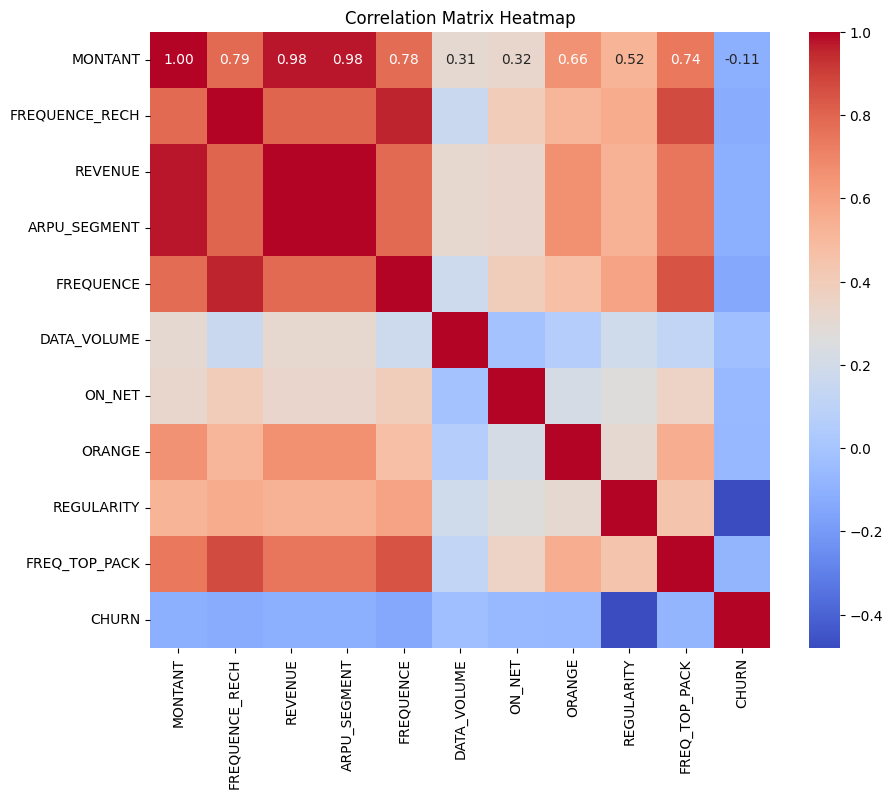

In [22]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data=df_num.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Hypothesis Test

* Null Hypothesis: There is a significant difference between tenure and churn

* Alternate Hypothesis: There is no significant difference between tenure and churn

Since 'Tenure' is a categorical variable and 'Churn' is a binary variable, we have to use a statistical test that is appropriate for categorical variables. Chi-squared test is one common test for this purposes. We create a 2X8 contingency table where the rows represent the two categories (Churned and Not Churned) and columns represent the 8 categories of Tenure. The cells of the table would contain the counts of observations falling into each combination of 'Churn' and 'Tenure' categories. 

In [33]:
# Create a 2X8 contingency table

contingency_table2 = pd.crosstab(df['CHURN'], df['TENURE'])
contingency_table2

TENURE,D 3-6 month,E 6-9 month,F 9-12 month,G 12-15 month,H 15-18 month,I 18-21 month,J 21-24 month,K > 24 month
CHURN,,,,,,,,
0,333,767,3459,5125,9389,16308,4910,834740
1,54,162,1145,2395,3524,6186,1414,187113


In [34]:
# Creating a 2x8 contingency table (replace this with your actual data)
contingency_table2 = pd.crosstab(df['CHURN'], df['TENURE'])


# Assuming 'contingency_table' is a 2x8 contingency table
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table2)

# Output the results
print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")

# Check significance
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between tenure and churn.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between tenure and churn.")

Chi-squared Statistic: 2898.520769181335
P-value: 0.0
Reject the null hypothesis. There is a significant difference between tenure and churn.


Insights in the hypothesis test: 
* Since different tenure groups impacts churn significantly, it could suggest that certain groups are more or less likely to churn.
* Higher average tenure might indicate higher churn risk, while lower average tenure might suggest lower churn risk.

Retention Strategies:

* A significant difference might prompt the development or enhancement of retention strategies.
* Strategies could include personalized offers, customer engagement initiatives, or improvements in customer service.


#### Analytical Questions

##### 1) What is the percentage of those who churned and those who did not?

In [26]:
# % of total customers churning
print('Total no. of customers :', df.CHURN.count())
perc_churn = (churn_df.CHURN.count()/df.CHURN.count())*100
print(f'Percentage of customer churning: {round(perc_churn,2)}%')

Total no. of customers : 1077024
Percentage of customer churning: 18.75%


CHURN
0    875031
1    201993
Name: count, dtype: int64



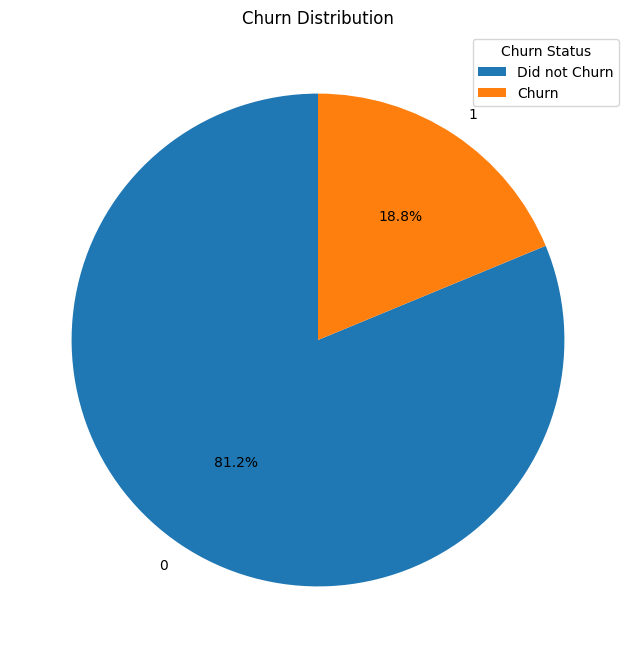

In [70]:
# Pie chart displaying those who churned and those who did not churn. 
# Visualize dependent variable (Churn)
print(df.CHURN.value_counts())
print('')

churn_counts = df['CHURN'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)

legend_labels={0:'Did not Churn',1:'Churn' }
plt.legend(legend_labels.values(), title='Churn Status', loc='upper right')

plt.title('Churn Distribution')
plt.show()

Insights:
From the chart we see that: 

* There were 875,031 customers who did not churn making 81.2%. 
* There were 201,993 customers who churned, making 18.8% 
* There is a need for immediate management action to avert further customer attrition. 


##### 2) How does tenure impact the likelihood of churning?

In [37]:
# Tenure and churn data

tenure_churn = churn_df.groupby(['TENURE'])['CHURN'].value_counts().reset_index()
#print(tenure_churn.sum())
tenure_churn

,TENURE,CHURN,count
0,D 3-6 month,1,54
1,E 6-9 month,1,162
2,F 9-12 month,1,1145
3,G 12-15 month,1,2395
4,H 15-18 month,1,3524
5,I 18-21 month,1,6186
6,J 21-24 month,1,1414
7,K > 24 month,1,187113


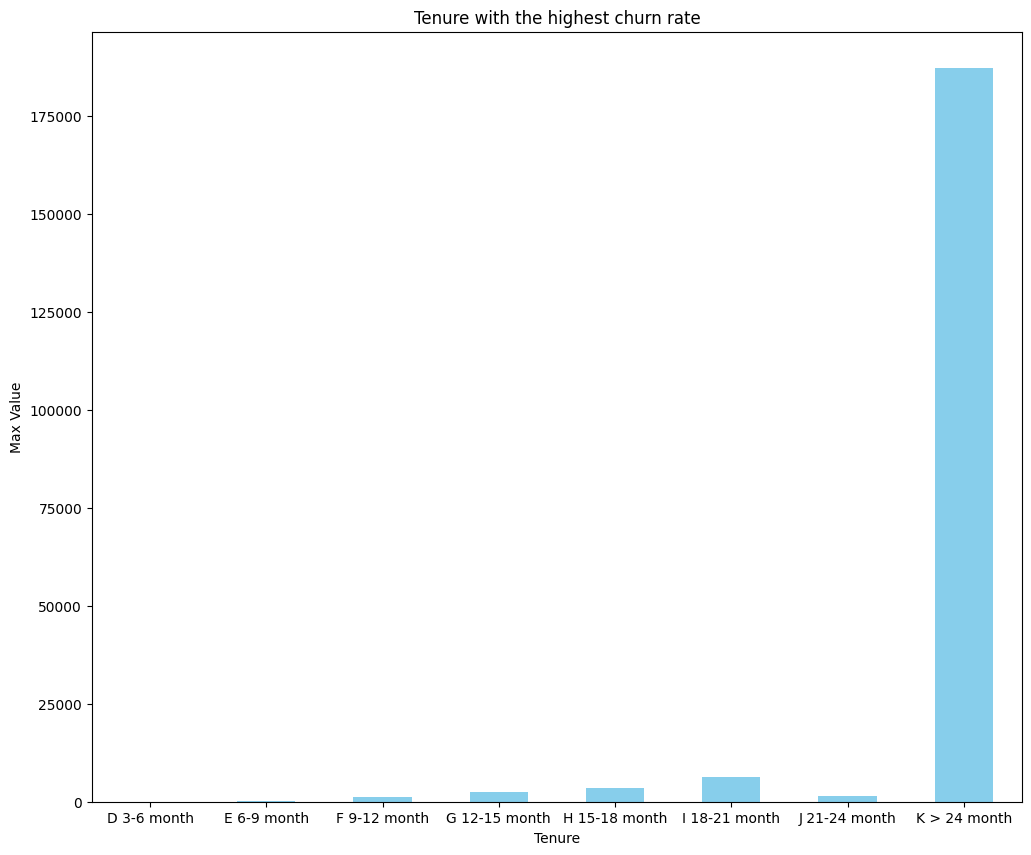

In [40]:
# Filter rows where 'CHURN' is equal to 1
churned_data = df[df['CHURN'] == 1]

# Group by 'TENURE' and find the maximum value for each 'TENURE'
max_tenure = churned_data.groupby('TENURE')['CHURN'].sum()

# Plot the results using a bar plot
plt.figure(figsize=(12, 10))
max_tenure.plot(kind='bar', color='skyblue')
plt.xlabel('Tenure')
plt.ylabel('Max Value')
plt.title('Tenure with the highest churn rate')
plt.xticks(rotation=0)
plt.show()

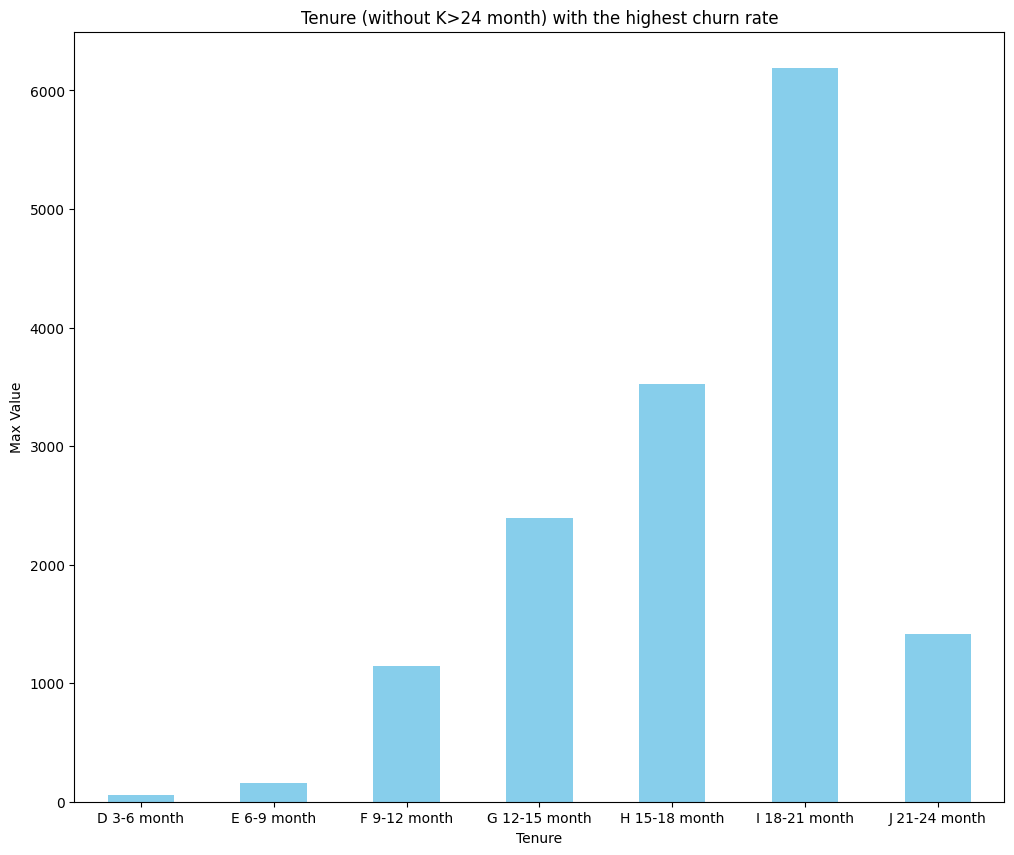

In [41]:
# Since K > 24 month is way higher than the rest we filter that out and plot for the others for better visualization

# Filter rows where 'CHURN' is equal to 1
churned_data = df[df['CHURN'] == 1]

# Group by 'TENURE' and find the maximum value for each 'TENURE'
max_tenure = churned_data.groupby('TENURE')['CHURN'].sum()
tenure_without_24month = max_tenure.drop(['K > 24 month'])


# Plot the results using a bar plot
plt.figure(figsize=(12, 10))
tenure_without_24month.plot(kind='bar', color='skyblue')
plt.xlabel('Tenure')
plt.ylabel('Max Value')
plt.title('Tenure (without K>24 month) with the highest churn rate')
plt.xticks(rotation=0)
plt.show()


Insights from graph above
 * Tenure > 24 month churned most, followed by 18-21 month, 15-18 month, 12-15 month, 21-24 month, 9-12 month, 6-9 month, and 3-6 month.
 * It is recommended that management further investigate why there is such a high attrition in customers who have stayed over 24 months with the company. This can be done through surveys on customers expectations so that management can design promotiona packages that will reduce this rate. 

##### 3) What is the distribution  of churn per region? Which region are customers leaving more?

In [32]:
# Region and churn rate
# show all the regions and the number of customer churn for each region


region_cust_churn = churn_df.groupby(['REGION'])['CHURN'].value_counts().reset_index(name='Churn_customer')
#print(region_cust_churn.sum())
region_cust_churn

,REGION,CHURN,Churn_customer
0,DAKAR,1,4931
1,DIOURBEL,1,919
2,FATICK,1,243
3,KAFFRINE,1,154
4,KAOLACK,1,1204
5,KEDOUGOU,1,21
6,KOLDA,1,216
7,LOUGA,1,799
8,MATAM,1,302
9,SAINT-LOUIS,1,728


In [102]:
# display regional churn in percentages

region_count = df['REGION'].value_counts()
percentage_region = (region_count / len(df)) * 100
print(percentage_region)

REGION
DAKAR          23.793249
THIES           8.372237
SAINT-LOUIS     5.561157
LOUGA           4.612618
KAOLACK         4.502964
DIOURBEL        3.116365
TAMBACOUNDA     2.559089
KAFFRINE        2.048887
KOLDA           1.807202
FATICK          1.650381
MATAM           1.360230
ZIGUINCHOR      1.024675
SEDHIOU         0.144194
KEDOUGOU        0.047724
Name: count, dtype: float64


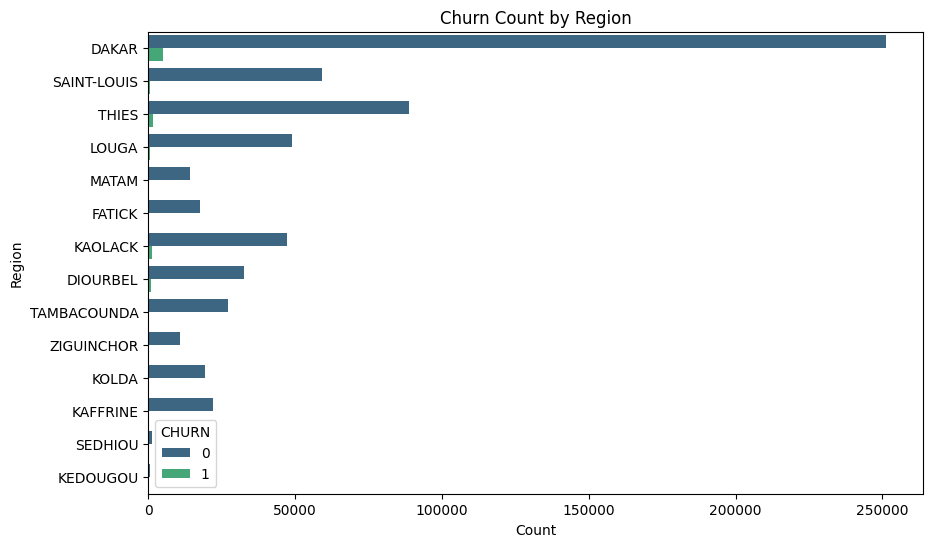

In [48]:
# Plot a horizontal bar plot for 'Region' with hue='Churn'

plt.figure(figsize=(10, 6))
sns.countplot(y='REGION', hue='CHURN', data=df, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Region')
plt.title('Churn Count by Region')
plt.show()

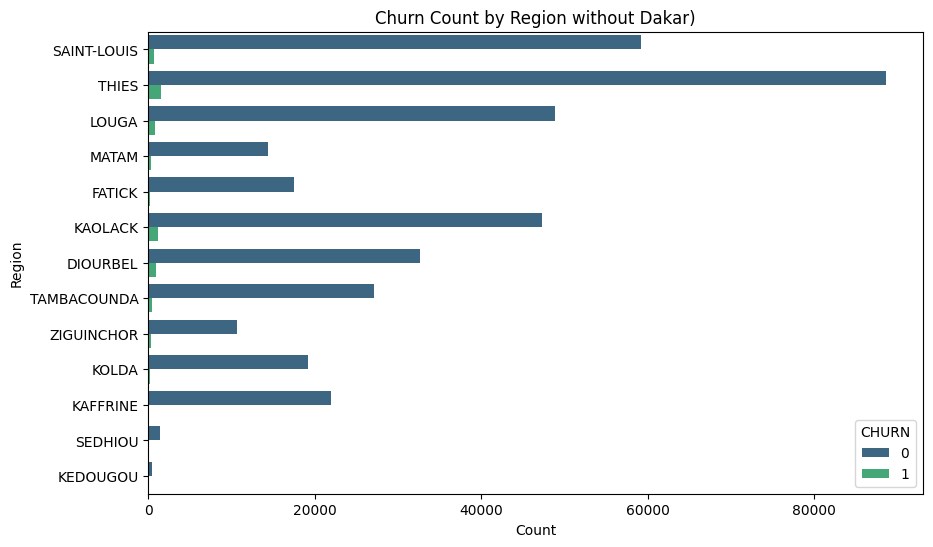

In [49]:

# Plot a horizontal bar plot for 'Region' with hue='Churn'

data_without_dakar=df[df['REGION']!='DAKAR']

plt.figure(figsize=(10, 6))
sns.countplot(y='REGION', hue='CHURN', data=data_without_dakar, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Region')
plt.title('Churn Count by Region without Dakar)')
plt.show()

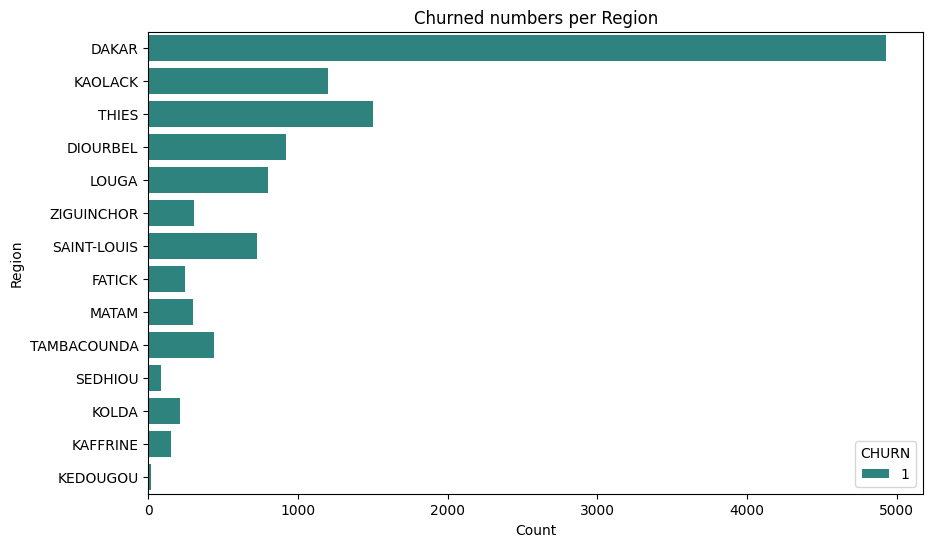

In [50]:
# Plot a horizontal bar plot for 'Region' with hue='Churn'
plt.figure(figsize=(10, 6))
sns.countplot(y='REGION', hue='CHURN', data=churned_data, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Region')
plt.title('Churned numbers per Region')
plt.show()

In [61]:
# Region churn in proportion to how many customers are in the region

region_cust_churn_perc = (df.groupby(['REGION'])['CHURN'].mean()*100).reset_index()
#region_cust_churn_perc

# Sort the DataFrame in descending order based on churn percentage
region_cust_churn_perc = region_cust_churn_perc.sort_values(by='CHURN', ascending=False)

# Remove the index
region_cust_churn_perc.reset_index(drop=True, inplace=True)

# Print the sorted DataFrame
print(region_cust_churn_perc)

         REGION     CHURN
0       SEDHIOU  5.408886
1      KEDOUGOU  4.085603
2    ZIGUINCHOR  2.745560
3      DIOURBEL  2.738053
4       KAOLACK  2.482577
5         MATAM  2.061433
6         DAKAR  1.924225
7         THIES  1.662397
8         LOUGA  1.608325
9   TAMBACOUNDA  1.585516
10       FATICK  1.367089
11  SAINT-LOUIS  1.215460
12        KOLDA  1.109741
13     KAFFRINE  0.697875


From the above we see that though Dakar churned most, proportionately, Sedhiou and Kedougou churned most at 5.4% and 4.08 respectively. However, Dakar and other regions with high client revenues must be kept in mind when making decisions. 

##### 4) Which top up amount churned most?

In [86]:

topup_churn = churn_df.groupby(['MONTANT'])['CHURN'].value_counts().reset_index(name='COUNT')

# Sort the DataFrame based on the count in descending order
topup_churn = topup_churn.sort_values(by='COUNT', ascending=False)

# Remove the index
topup_churn.reset_index(drop=True, inplace=True)

# Print the top 10 entries
print(topup_churn.head(10))

   MONTANT  CHURN  COUNT
0    500.0      1   6612
1   1000.0      1   3667
2    200.0      1   2871
3    100.0      1   1824
4   1500.0      1   1586
5   2000.0      1   1452
6   3000.0      1    869
7    300.0      1    803
8   2500.0      1    769
9    250.0      1    702


In [100]:
topup_churn.tail(10)

,MONTANT,CHURN,COUNT
555,51500.0,1,1
554,50600.0,1,1
553,50500.0,1,1
492,26300.0,1,1
494,26550.0,1,1
551,48100.0,1,1
496,26700.0,1,1
497,26900.0,1,1
549,44750.0,1,1
573,286500.0,1,1


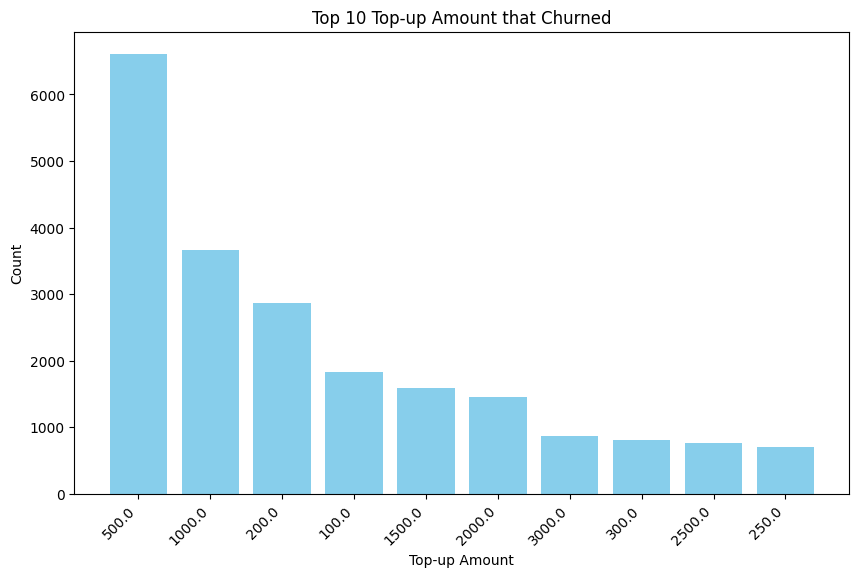

In [87]:

topup_churn = churn_df.groupby(['MONTANT'])['CHURN'].value_counts().reset_index(name='COUNT')

# Sort the DataFrame based on the count in descending order
topup_churn = topup_churn.sort_values(by='COUNT', ascending=False)

# Take the top 10 entries
top_10_entries = topup_churn.head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_10_entries)), top_10_entries['COUNT'], color='skyblue')
plt.xlabel('Top-up Amount')
plt.ylabel('Count')
plt.title('Top 10 Top-up Amount that Churned')
plt.xticks(range(len(top_10_entries)), top_10_entries['MONTANT'].astype(str), rotation=45, ha='right')
#plt.tight_layout()
plt.show()

From the graph above, it shows that top-up amount of 500 churned most. This is followed by 1000, 200, and 100 respectively. 

##### 5) What is the effect of the number of times a customer activates top pack packages and likelihood of churning?

In [82]:

freq_top_pack_churn = churn_df.groupby(['FREQ_TOP_PACK'])['CHURN'].value_counts().reset_index(name='COUNT')

# Sort the DataFrame based on the count in descending order
freq_top_pack_churn = freq_top_pack_churn.sort_values(by='COUNT', ascending=False)

# Print the top 10 entries
print(freq_top_pack_churn.head(10))

   FREQ_TOP_PACK  CHURN  COUNT
0            1.0      1  10844
1            2.0      1   4381
2            3.0      1   2429
3            4.0      1   1582
4            5.0      1   1148
5            6.0      1    809
6            7.0      1    670
7            8.0      1    519
8            9.0      1    403
9           10.0      1    351


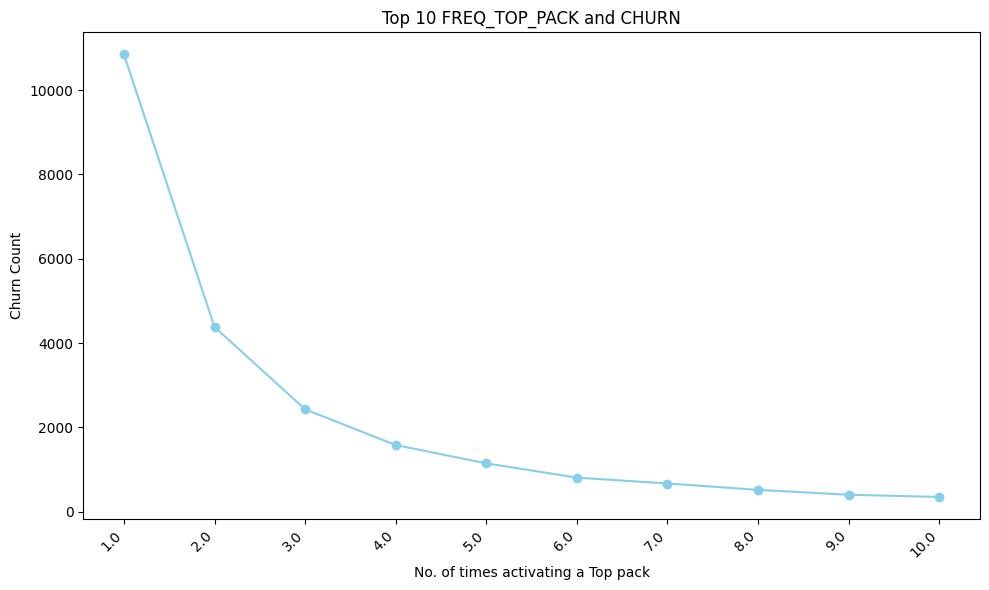

In [116]:
# Plotting a line chart for top 10 entries
plt.figure(figsize=(10, 6))
plt.plot(top_10_entries['FREQ_TOP_PACK'].astype(str), top_10_entries['COUNT'], marker='o', linestyle='-', color='skyblue')
plt.xlabel('No. of times activating a Top pack')
plt.ylabel('Churn Count')
plt.title('Top 10 FREQ_TOP_PACK and CHURN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The graph above shows that customers who least activated top packs were more likely to churn. On average when sum of the number of times customers activate a top pack decreases, churn count increases.  

##### 6) Is there an effect of regularity on churn?
Does the number of times the client is active in 90 days say anything about the posibility of churning?

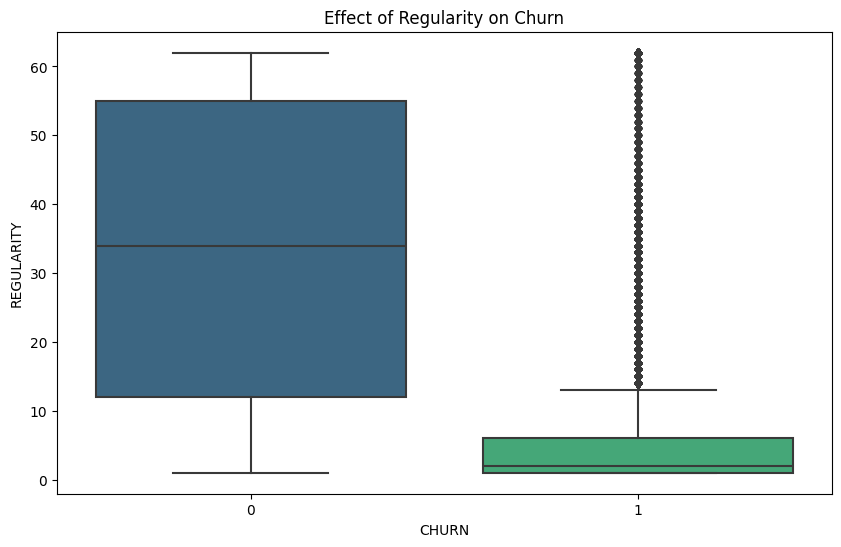

In [61]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='CHURN', y='REGULARITY', data=df, palette='viridis')
plt.xlabel('CHURN')
plt.ylabel('REGULARITY')
plt.title('Effect of Regularity on Churn')
plt.show()

## Data Preparation

## Modelling 